# From boosted trees to a single tree

## Introduction

A simple decision tree is often considered to be the easiest model to understand, which is often good when the for commissioner of a model is cautious about deploying the model and wants to understand it or for regulatory purposes where interpretability is key. However, newer approaches such as boosted trees, random forests and even neural networks often have much improved predictive power. These techniques are not as "black box" as often claimed and it is possible to understand what features are contributing the model, but this might not always be good enough.

Here the approach of Domingos<sup>[1]</sup> (_Knowledge acquisition from examples via multiple models_) is explored which allows a simple model to be built on top of a more complex model. This would allow, for example, a decision tree to be built on the results from a gradient boosted decision tree. The idea being that this decision tree is much more accurate than a decision tree trained on only the real data and is arguably more interpretible than the boosted tree itself.

Related ideas (see, for example, _Do Deep Nets Really Need to be Deep?_ by Ba and Caruana<sup>[2]</sup>) are being used to train shallow neural networks from deep neural networks. These shallow neural networks are then able to have predictive power similar to the deep networks; more predictive power than they could achieve from training on the data alone. The motivation being that these shallow networks are more parallelisable, so are quicker at making predictions when deployed.
 
[1]:http://homes.cs.washington.edu/~pedrod/papers/mlc97.pdf
[2]:https://arxiv.org/abs/1312.6184

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Generating example data
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits

# Evaluation
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Classifiers used
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Visualising the decision trees
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz

## Demonstration of the basic principle

Let's start by creating a dataset to classify which contains just two classes.

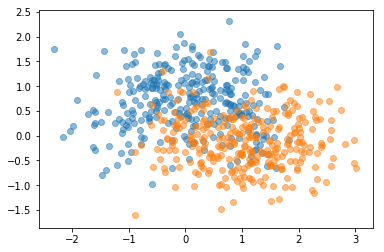

In [2]:
X, y = make_moons(n_samples=600, shuffle=True, noise=0.5, random_state=40)

plt.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.5)
plt.show()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40 )

A simple model can be fitted to the data and the model evaluated on the test data. Decision trees are ideal here as they are easy to interpret and can produce non-linear decision boundaries.

In [3]:
model_simp = DecisionTreeClassifier(max_depth=5, random_state=40)
model_simp.fit(X_train, y_train)

print classification_report(y_test, model_simp.predict(X_test))

             precision    recall  f1-score   support

          0       0.88      0.78      0.82       103
          1       0.79      0.88      0.83        95

avg / total       0.83      0.83      0.83       198



Fitting a more complex model results in smaller classification errors. Here a gradient boosted decision tree is used, but a neural network or random forest model could have been used instead.

In [4]:
model_comp = XGBClassifier(max_depth=4, n_estimators=250)
model_comp.fit(X_train, y_train)

print classification_report(y_test, model_comp.predict(X_test))

             precision    recall  f1-score   support

          0       0.92      0.78      0.84       103
          1       0.79      0.93      0.85        95

avg / total       0.86      0.85      0.85       198



The approach of Domingos is based on applying the simple model to the predictions for the classes of the complex model (on the training data) rather than the actual data. For example:

In [5]:
y_new = model_comp.predict(X_train)

model_simp2 = DecisionTreeClassifier(max_depth=3, random_state=40)
model_simp2.fit(X_train, y_new)

print classification_report(y_test, model_simp2.predict(X_test))

             precision    recall  f1-score   support

          0       0.84      0.84      0.84       103
          1       0.83      0.83      0.83        95

avg / total       0.84      0.84      0.84       198



The idea is that the new simple model (here called _model_\__simp2_) produces errors much closer to the complex model (_model_\__comp_) than training a simple model on the original data (_model_\__simp_). 

The important thing to note is that only the **labels** are changed, the **features** have not been touched. This means that the simple model can be applied to new data when deployed (this new data having features but no labels) without the complex model being used or accessible. The complex model was only used to help train the simple model and, therefore, can be discarded. The actual predictions generated are produced by the simple model **alone**, so only this model needs interpreting.

### More sophisticated approach

The approach proposed by Domingos (called the CMM meta-learning algorithm) is more complex as instead of re-training the simple model he suggests using a mixture of the original data and data with changed labels. This is generated by picking a random sample of the data, changing their labels using the predictions of the complex model, and then added togehter the orginal data and the re-labelled sample. This is demonstrated below.

In [6]:
# Function to pick random data points
def random_points(X, n, replace=False, seed=None):
    np.random.seed(seed)
    random_ind = np.random.choice(X.shape[0], n, replace=replace)
    X_new = X[random_ind,:]
    return X_new

# Generate additional points
X_add = random_points(X_train, 100, seed=70)

# Predict their classes using complex model
y_add = model_comp.predict(X_add)

# Add these points to training data
X_train_more =np.append(X_train, X_add, axis=0)
y_train_more =np.append(y_train, y_add, axis=0)

# Train simple model
model_simp3 = DecisionTreeClassifier(max_depth=3, random_state=40)
model_simp3.fit(X_train_more, y_train_more)

print classification_report(y_test, model_simp3.predict(X_test))

             precision    recall  f1-score   support

          0       0.92      0.81      0.86       103
          1       0.81      0.93      0.87        95

avg / total       0.87      0.86      0.86       198



In this case mixing re-labelled data and original data provided an improvement. Note, in the examples above the hyperparameters have been tuned but better tuning could improve the results making comparisions even fairer.

## Why does this work?

At first it seems strange that this approach works. We are re-training the simple model with re-labelled data, so instead of feeding it the truth we are feeded it data which contains points that have been misclassified by the complex model.

By plotting both the orginal training data and the re-labelled training data we can gain insight into why this approach works.

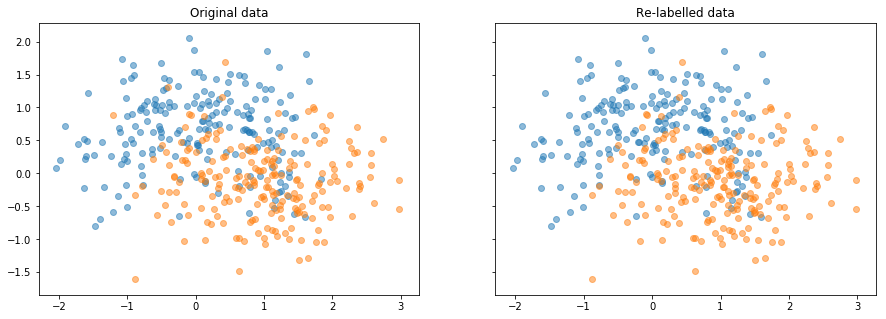

In [7]:
fig, (sub1, sub2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
sub1.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], alpha=0.5)
sub1.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], alpha=0.5)
sub1.set_title('Original data')

sub2.scatter(X_train[y_new == 0, 0], X_train[y_new == 0, 1], alpha=0.5)
sub2.scatter(X_train[y_new == 1, 0], X_train[y_new == 1, 1], alpha=0.5)
sub2.set_title('Re-labelled data')

plt.show()


It is difficult to see what exactly has changed so let's plot the changes but colour them by their class in the original data.

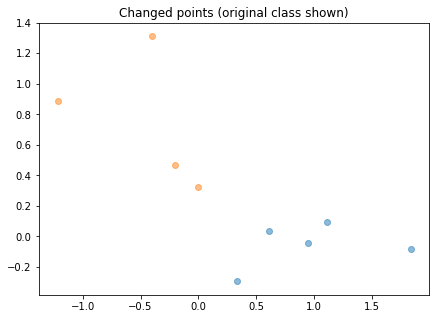

In [8]:
# Changed points:
#  -1 indicates 1 changed to 0 
#  +1 indicates 0 changed to 1
y_changed = y_train - y_new


fig, sub3 = plt.subplots(figsize=(7,5))
sub3.scatter(X_train[y_changed == -1, 0], X_train[y_changed == -1, 1], alpha=0.5)
sub3.scatter(X_train[y_changed == 1, 0], X_train[y_changed == 1, 1], alpha=0.5)
sub3.set_title('Changed points (original class shown)')

plt.show()

In the re-labelled some of the noise has been removed and the classes are therefore better seperated. It is, therefore, easier for the simple classifier to find a decision boundary that seperates the two classes. It is being guided by where the complex model thinks misclassifications are OK in order to produce an overall more accurate model. So whilst the simple model is expressive enough to create a good decision boundary it was not able to learn this boundary as well as the complex model.

A (not brilliant) analogy would be to consider two golders: one a golf pro and one an amateur. The golf pro would be much better at hitting the ball towards the fairway than the amateur as he is better able to judge the conditions of each hole, but the amateur can improve his game by looking at what the pro does rather than just his own judgement about the right shot to take. 

## Visualising the tree

Following the scikit-learn documentation you can visualise the simple tree as follows (note you will need graphviz installed).

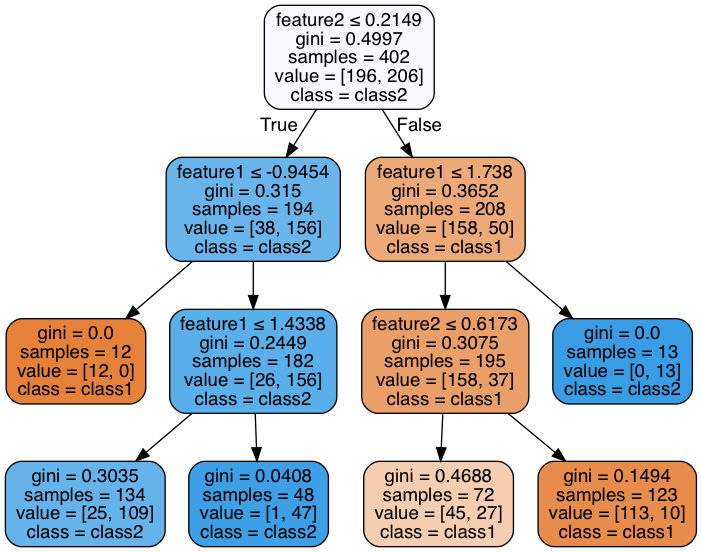

In [9]:
dot_data = export_graphviz(model_simp2, out_file=None, 
                         feature_names=["feature1", "feature2"],  
                         class_names=["class1", "class2"],  
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Let's compare this to the tree produced by the original single decision tree trained against the original (not re-labelled) data.

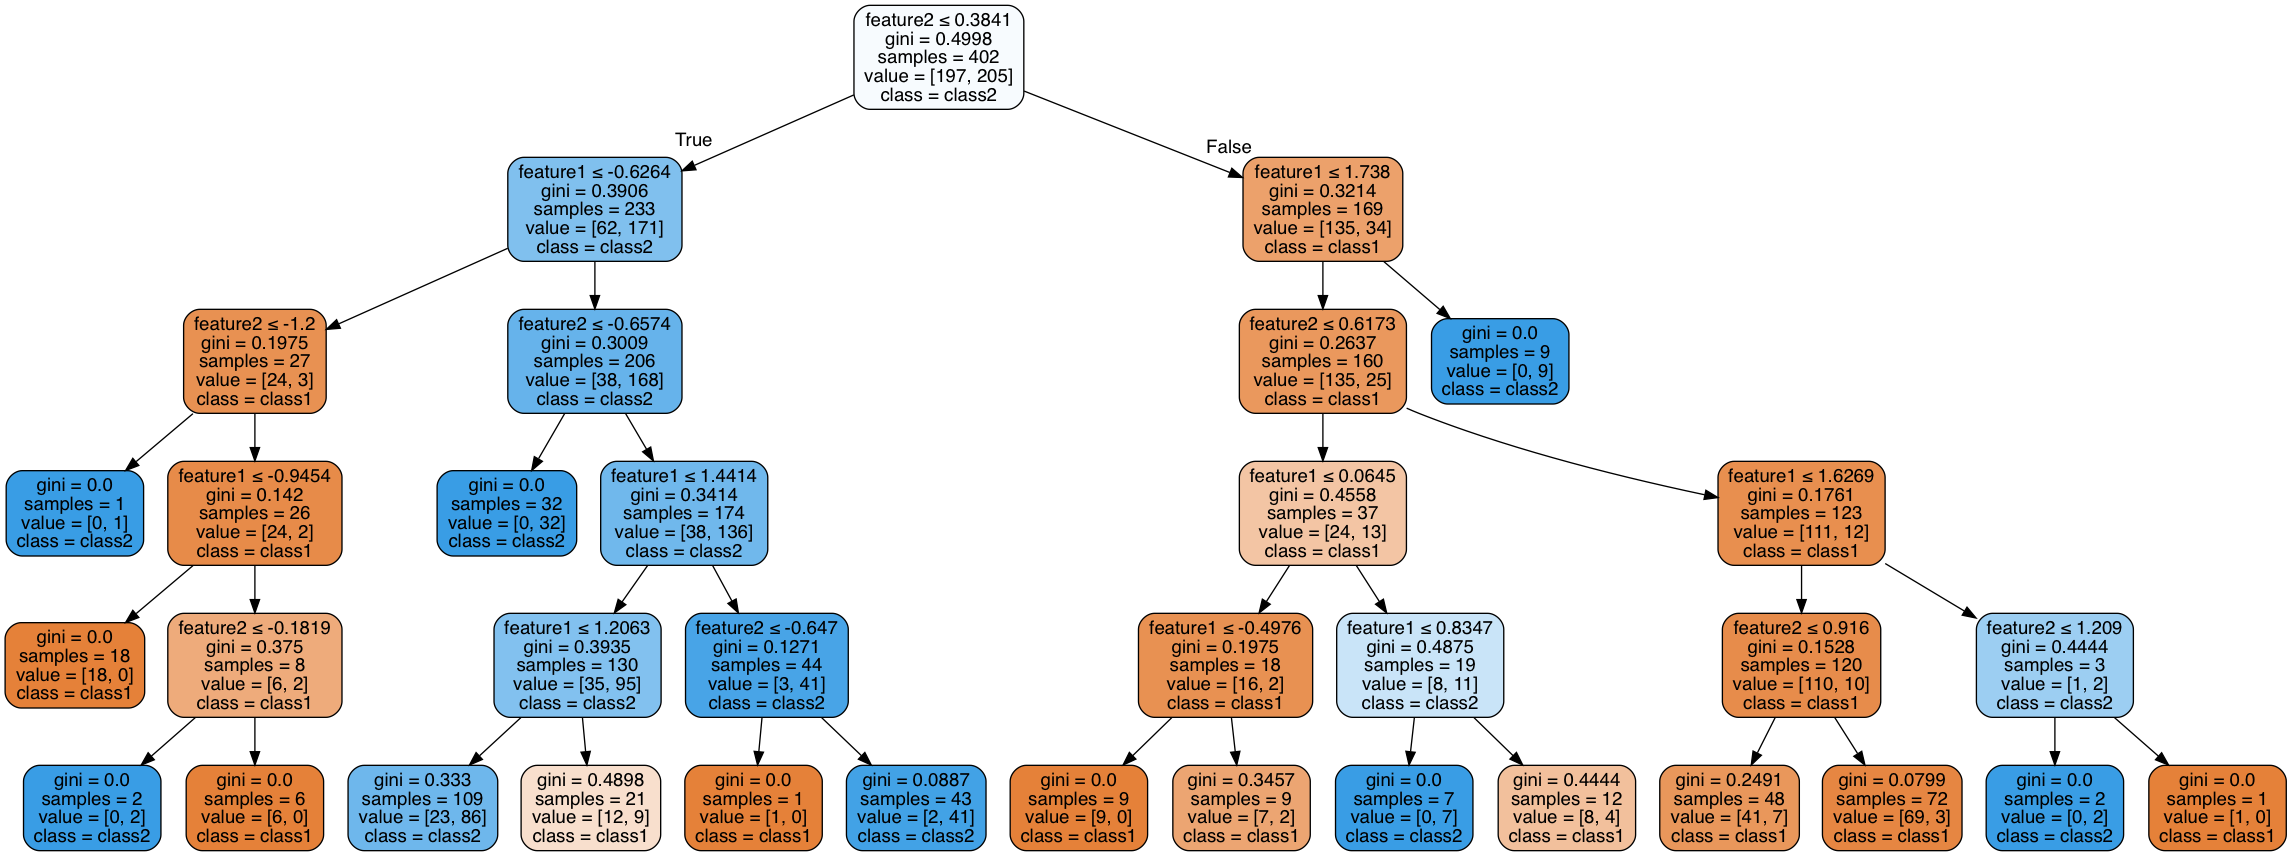

In [10]:
dot_data = export_graphviz(model_simp, out_file=None, 
                         feature_names=["feature1", "feature2"],  
                         class_names=["class1", "class2"],  
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Interestingly this decision tree is more complicated than the one trained on the relabelled data. So not only has accuracy improved but interpretability!

This makes sense as in effect the re-labelling has removed noise from the data so the decision does not need as many splits to classify it. However, whether the tree is larger or smaller after re-labelling would likely depend on the exact dataset being considered.

## An example where this doesn't work

This approach will not always work. To illustrate consider the example below. Here we use images of digits hand-written digits which we want to classify.

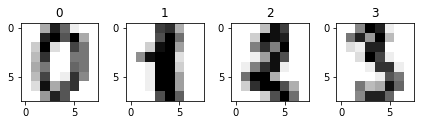

In [11]:
# Load the data
data = load_digits(n_class=10, return_X_y=True)
X_digits = data[0]
y_digits = data[1]

# Train/test split
Xd_train, Xd_test, yd_train, yd_test = train_test_split(
                                    X_digits, y_digits, test_size=0.33, random_state=40 )

# Plot some of the data
plt.figure()
for i in range(4):
    ax= plt.subplot(1,4 ,i+1)
    im=ax.imshow(X_digits[i].reshape([8,8]), cmap=plt.cm.gray_r)
    plt.title(y_digits[i])
    plt.tight_layout()
    
plt.show()

Let's repeat the process from before: first train a single decision tree on the data; then train a gradient boosted decision tree on the data; use this more complex model to re-label the training data; and finally re-train the single decision tree.

In [12]:
# Simple model trained on original data
digits_simp = DecisionTreeClassifier(max_depth=10, random_state=40)
digits_simp.fit(Xd_train, yd_train)
simp_f1 = f1_score(yd_test, digits_simp.predict(Xd_test), average='micro')

# Complex model trained on orginal data
digits_comp = XGBClassifier(max_depth=5, n_estimators=250)
digits_comp.fit(Xd_train, yd_train)
comp_f1 = f1_score(yd_test, digits_comp.predict(Xd_test), average='micro')

# Simple model trained on re-labelled data
yd_new = digits_comp.predict(Xd_train)
digits_simp2 = DecisionTreeClassifier(max_depth=9, random_state=40)
digits_simp2.fit(Xd_train, yd_new)
simp2_f1 = f1_score(yd_test, digits_simp2.predict(Xd_test), average='micro')

print "F1-score simple model (original data):", simp_f1
print "F1-score complex model (original data):", comp_f1
print "F1-score simple model (re-labelled data):", simp2_f1

F1-score simple model (original data): 0.833333333333
F1-score complex model (original data): 0.961279461279
F1-score simple model (re-labelled data): 0.833333333333


In this case the complex model produces an excellent classifier, but re-training the simple model on the re-labelled data does not improve its performance. There are two potential reasons for this:
1. The single decision tree is not capable of producing a functional form that seperates the digits with the desired accuracy.
2. The complex model has not been able to transfer its learning to the simple model.

In my opinion the later is more likely to be the deciding factor here. Note that the boosted tree produces a really good classifier, which means that it will hardly ever misclassify the training data. This in turn means that it will not re-label many data points. As this re-labelling is the sole method by which it can transfer its learning to the single tree you would not expect the single tree to improve.

What this shows is that this approach should not be seen as a way in which to aid interpretability of more complex models (as the accuracy of the simplier model might not approach that of the more complex model), but as a method which sometimes allows simplier (and more interpretable) models to gain better accuracy, accuracy that may approach that of the more complex models in some circumstances.

## Interpreting boosted decision trees

Boosted decisions and random forests are not quite the black boxes they are sometimes presented as. Instead fitting of a single decision tree onto their outputs (which does not seem to be used often) people tend to look at **feature importance**.

To demonstrate we can output the feature importances for our complex model.

In [13]:
from xgboost import plot_importance

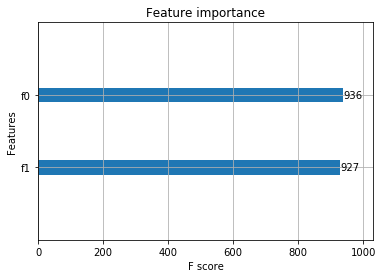

In [14]:
plot_importance(model_comp)
plt.show()

As there were only two features the graph is not very informative. These plots show which features are most important to the model overall.

Another apporach is to plot partial depency curves (implemented in scikit-learn but not xgboost) which plots out how the prediction changes when a variable changes, holding constant the contribution of the other variables (http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html). These plots only make sense if, roughly speaking, the predictions can be considered as depending on the most important variables seperately (they don't interact).

Another approach is to trace out the prediction path through the tree for any given prediction. For sci-kit learn models this has been implemented in the treeinterpreter package (https://github.com/andosa/treeinterpreter). This has not been implemented in xgboost yet but it, in effect, gives feature importance for each prediction showing the features that most influenced that particular result.